In [75]:
import scipy.integrate
import matplotlib.pyplot as plt
import numpy as np

from diffractio import um, np
from diffractio.scalar_sources_X import Scalar_source_X
from diffractio.scalar_masks_X import Scalar_mask_X
from diffractio.scalar_sources_XY import Scalar_source_XY
from diffractio.scalar_masks_XY import Scalar_mask_XY
import cupy as cp
import cupyx as cpx
%matplotlib ipympl



In [76]:
def diffractio_rs_aperture_2D(x0, 
                              y0,
                              z_prop,
                              aperture_width, 
                              wavelength,
                              draw_inputs=False):

    # Make scalar source
    u0 = Scalar_source_XY(x0, y0, wavelength)
    u0.plane_wave(z0=0)

    # Make scalar diffraction mask
    t0=Scalar_mask_XY(x0, y0, wavelength)
    t0.slit(x0=0, size=aperture_width*um, angle=0)
    t0.circle(r0=(0 * um, 0 * um), radius=(aperture_width / 2 * um, aperture_width / 2 * um), angle=0)
    u1=t0*u0
    z = z_prop
    u2 = u1.RS(z=z, new_field=True)

    if draw_inputs:
        u0.draw(kind='intensity')
        t0.draw(kind='intensity')

    return u2


In [77]:
mempool = cp.get_default_memory_pool()

with cp.cuda.Device(0):
    mempool.set_limit(size=10*1024**3)

def monte_carlo_diffraction_cupy_2D(N_total, 
                                    final_image_real,
                                    final_image_imag,
                                    source_width_x,
                                    source_width_y,
                                    slit_radius,
                                    det_yx,
                                    z_prop,
                                    wavelength,
                                    batch_size=int(1e7)):  # Batch size of rays to GPU
    y_det = det_yx.shape[1]
    x_det = det_yx.shape[2]

    pdf = 1 / (source_width_x * source_width_y)
    
    # Initialize arrays to count the number of rays per pixel
    counts = cp.zeros((y_det, x_det), dtype=cp.int32)
    for start_idx in range(0, N_total, batch_size):
        end_idx = min(start_idx + batch_size, N_total)
        current_batch_size = end_idx - start_idx

        # Get random pixel samples of the source (or aperture) and the detector
        source_x = cp.random.uniform(-source_width_x/2, source_width_x/2, size=current_batch_size)
        source_y = cp.random.uniform(-source_width_y/2, source_width_y/2, size=current_batch_size)
        source_z = cp.zeros(current_batch_size)
        
        aperture_mask = (np.sqrt((source_x **2 + source_y ** 2)) < slit_radius)
        U = (aperture_mask).astype(cp.int32) / pdf

        # rand_theta = np.random.uniform(0, np.pi, N_aperture)
        rand_det_idx_x = cp.random.randint(x_det, size=current_batch_size)
        rand_det_idx_y = cp.random.randint(y_det, size=current_batch_size)
        
        cp.add.at(counts, (rand_det_idx_y, rand_det_idx_x), 1)

        det_x = det_yx[1, rand_det_idx_y, rand_det_idx_x]
        det_y = det_yx[0, rand_det_idx_y, rand_det_idx_x]
        det_z = cp.ones(current_batch_size) * z_prop

        # Convert coordinates to a vector for convenience
        ray_source_coord = cp.array([source_z, source_y, source_x])
        ray_det_coord = cp.array([det_z, det_y, det_x])
        
        # Create ray vector and get magnitude and direction
        ray = ray_det_coord - ray_source_coord
        ray_magnitude = cp.linalg.norm(ray, axis = 0)

        k = 2 * np.pi / wavelength
        complex_rays = (1 / ray_magnitude) * (1 / (2 * np.pi)) * (1j * k * z_prop / ray_magnitude) * (np.exp(1j * (k * ray_magnitude))) * U

        # Add complex wavefront to each pixel in the image
        cpx.scatter_add(final_image_real, (rand_det_idx_y, rand_det_idx_x), complex_rays.real)
        cpx.scatter_add(final_image_imag, (rand_det_idx_y, rand_det_idx_x), complex_rays.imag)
        
    final_image = (final_image_real + 1j * final_image_imag)
    
    non_zero_counts = counts > 0
    final_image[non_zero_counts] *= 1 / counts[non_zero_counts]
    
    # Include final factors which scale image by pixel size, and have an extra term from the rayleigh sommerfeld integral. 
    return final_image, ray_source_coord, ray_det_coord, aperture_mask

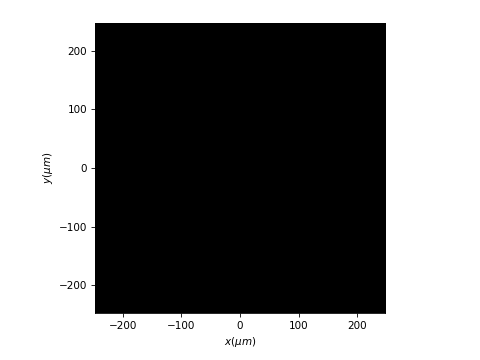

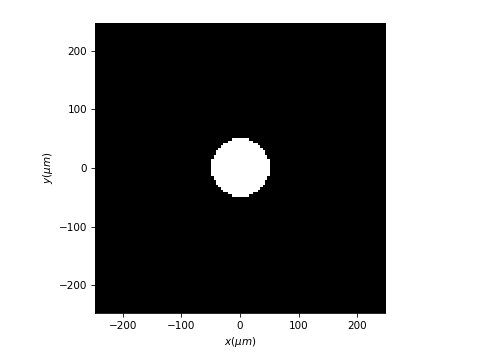

In [78]:

aperture_diameter = 100 * um
detector_width_x = 500 * um
detector_width_y = 500 * um

num_px_det_x = 125
num_px_det_y  = 125

detector_px_width_x = detector_width_x / num_px_det_x 
detector_px_width_y = detector_width_y / num_px_det_y

num_pixels = int(num_px_det_x*num_px_det_y)
det_yx_indices = np.indices((num_px_det_y, num_px_det_x)).reshape(2, num_pixels).T

det_yx_coords = np.zeros(det_yx_indices.shape, dtype = np.float64)
det_yx_coords[:, 0] = det_yx_indices[:, 0] * detector_px_width_y - detector_width_y / 2  + detector_px_width_y / 2
det_yx_coords[:, 1] = det_yx_indices[:, 1] * detector_px_width_x - detector_width_x / 2  + detector_px_width_x / 2 
det_yx_coords = det_yx_coords.T.reshape(2, num_px_det_y, num_px_det_x)

z_prop = 500 * um
wavelength = 1 * um

u2 = diffractio_rs_aperture_2D(x0=det_yx_coords[1, 0, :], y0=det_yx_coords[1, 0, :],
                                z_prop=z_prop, 
                                wavelength=wavelength,
                                aperture_width=aperture_diameter, 
                                draw_inputs=True)



In [79]:

num_rays=int(1e10)

source_width_x = detector_width_x
source_width_y = detector_width_y
det_yx_coords = cp.asarray(det_yx_coords)

# Initialize final image and aperture phase shifts arrays on GPU
final_image_real = cp.zeros([num_px_det_y, num_px_det_x], dtype=cp.float64)
final_image_imag = cp.zeros([num_px_det_y, num_px_det_x], dtype=cp.float64)

final_image, ray_aper_coord, ray_det_coord, aperture_mask = monte_carlo_diffraction_cupy_2D(num_rays, 
                                                                                            final_image_real,
                                                                                            final_image_imag,
                                                                                            source_width_x,
                                                                                            source_width_y,
                                                                                            slit_radius=aperture_diameter/2,
                                                                                            det_yx=det_yx_coords,
                                                                                            z_prop=z_prop,
                                                                                            wavelength=wavelength,
                                                                                            batch_size=int(1e7),
                                                                                            )

det_yx_coords = cp.asnumpy(det_yx_coords)
final_image = cp.asnumpy(final_image)
ray_aper_coord = cp.asnumpy(ray_aper_coord)
ray_det_coord = cp.asnumpy(ray_det_coord)
aperture_mask = cp.asnumpy(aperture_mask)

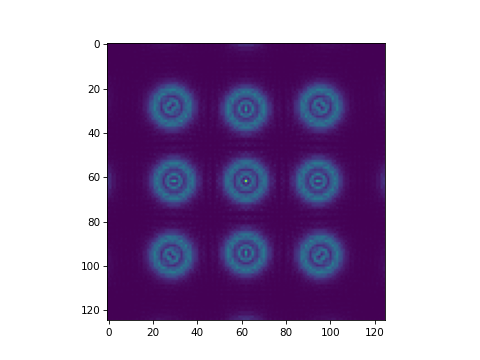

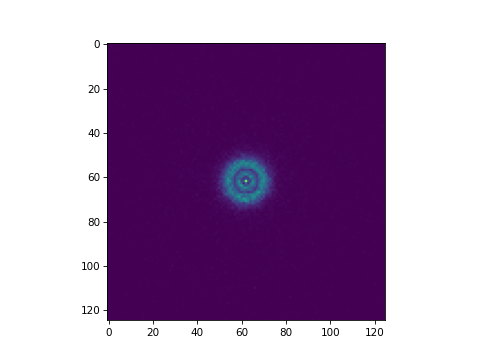

In [80]:

fig, ax = plt.subplots()
ax.imshow(np.abs(u2.u) ** 2, label='Diffraction RayLeigh Sommerfeld')

fig, ax = plt.subplots()
ax.imshow(np.abs(final_image) ** 2)


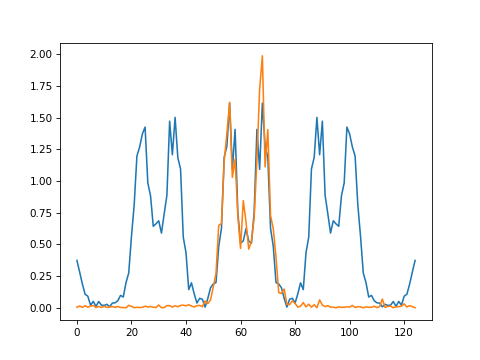

In [84]:
plt.figure()
plt.plot(np.abs(u2.u[67, :]) ** 2)
plt.plot(np.abs(final_image[67, :]) ** 2)